### Libraries

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

### 1. Network Architecture
In a network architecture, every agent can communicate with every other agent. This creates a flexible, many-to-many communication pattern.

In [18]:
from typing import Literal
# from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END

# model = ChatOpenAI(temperature=0)
model = ChatBedrock(model_id="anthropic.claude-3-5-sonnet-20241022-v2:0",region_name="us-west-2")    

def researcher_agent(state: MessagesState) -> Command[Literal["writer_agent", "reviewer_agent", END]]:
    """Agent that researches topics and decides next step"""
    messages = state.get("messages", [])
    
    # Simple logic to determine next agent
    if not messages or "research complete" not in str(messages[-1]).lower():
        research_result = "Research complete: Found 5 key points about AI architectures"
        next_agent = "writer_agent"
    else:
        next_agent = END
    
    return Command(
        goto=next_agent,
        update={"messages": [f"[RESEARCHER]: {research_result}"]}
    )

def writer_agent(state: MessagesState) -> Command[Literal["researcher_agent", "reviewer_agent", END]]:
    """Agent that writes content based on research"""
    messages = state.get("messages", [])
    
    if any("research complete" in str(msg).lower() for msg in messages):
        content = "Draft article written based on research findings"
        next_agent = "reviewer_agent"
    else:
        next_agent = "researcher_agent"
    
    return Command(
        goto=next_agent,
        update={"messages": [f"[WRITER]: {content}"]}
    )

def reviewer_agent(state: MessagesState) -> Command[Literal["researcher_agent", "writer_agent", END]]:
    """Agent that reviews and provides feedback"""
    messages = state.get("messages", [])
    
    if any("draft article" in str(msg).lower() for msg in messages):
        review = "Article reviewed and approved for publication"
        next_agent = END
    else:
        next_agent = "researcher_agent"
    
    return Command(
        goto=next_agent,
        update={"messages": [f"[REVIEWER]: {review}"]}
    )

# Build the network
builder = StateGraph(MessagesState)
builder.add_node("researcher_agent", researcher_agent)
builder.add_node("writer_agent", writer_agent)
builder.add_node("reviewer_agent", reviewer_agent)

builder.add_edge(START, "researcher_agent")
network = builder.compile()

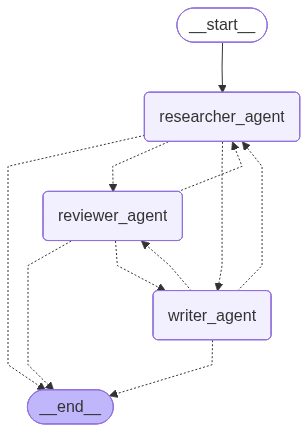

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        network.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [21]:
# Test the network
result = network.invoke({"messages": ["Start research project"]})
for message in result["messages"]:
    print(message)

content='Start research project' additional_kwargs={} response_metadata={} id='f908f35a-e7c9-4578-939b-dc687a3a79d3'
content='[RESEARCHER]: Research complete: Found 5 key points about AI architectures' additional_kwargs={} response_metadata={} id='46a9a420-dc9b-466c-9214-b3d58ebffcc4'
content='[WRITER]: Draft article written based on research findings' additional_kwargs={} response_metadata={} id='19edebc6-9f65-4f59-8d88-2ec9a87419c4'
content='[REVIEWER]: Article reviewed and approved for publication' additional_kwargs={} response_metadata={} id='394ff21f-0efb-442a-9306-0903f273aa1b'


### 2. Supervisor Architecture
In this pattern, a central supervisor coordinates all other agents, making routing decisions.

In [22]:
from typing import Literal
# from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END

# model = ChatOpenAI(temperature=0)

def supervisor(state: MessagesState) -> Command[Literal["content_creator", "editor", END]]:
    """Supervisor decides which agent should work next"""
    messages = state.get("messages", [])
    
    if not messages:
        return Command(goto="content_creator")
    
    last_message = str(messages[-1]).lower()
    
    if "content created" in last_message and "edited" not in last_message:
        return Command(goto="editor")
    elif "edited and polished" in last_message:
        return Command(goto=END)
    else:
        return Command(goto="content_creator")

def content_creator(state: MessagesState) -> Command[Literal["supervisor"]]:
    """Creates initial content"""
    content = "Content created: 'Introduction to Multi-Agent Systems'"
    return Command(
        goto="supervisor",
        update={"messages": [f"[CREATOR]: {content}"]}
    )

def editor(state: MessagesState) -> Command[Literal["supervisor"]]:
    """Edits and polishes content"""
    edit = "Content edited and polished for publication"
    return Command(
        goto="supervisor",
        update={"messages": [f"[EDITOR]: {edit}"]}
    )

# Build supervisor system
builder = StateGraph(MessagesState)
builder.add_node("supervisor", supervisor)
builder.add_node("content_creator", content_creator)
builder.add_node("editor", editor)

builder.add_edge(START, "supervisor")
supervisor_system = builder.compile()

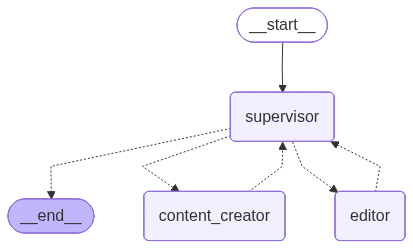

In [23]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        supervisor_system.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [24]:
# Test the supervisor system
result = supervisor_system.invoke({"messages": []})
for message in result["messages"]:
    print(message)

content="[CREATOR]: Content created: 'Introduction to Multi-Agent Systems'" additional_kwargs={} response_metadata={} id='643ae686-669d-4231-bb7b-5d8d9657ab6c'
content='[EDITOR]: Content edited and polished for publication' additional_kwargs={} response_metadata={} id='d6debaf8-3510-49f1-b43a-041fa4852c5f'


### 3. Supervisor with Tool-Calling
This approach treats agents as tools that the supervisor can call, leveraging the LLM's natural tool-calling capabilities.


In [2]:
from typing import Annotated
# from langchain_openai import ChatOpenAI
from langchain_aws import ChatBedrock

from langgraph.prebuilt import InjectedState, create_react_agent
from langchain_core.tools import tool

model = ChatBedrock(model_id="anthropic.claude-3-5-sonnet-20241022-v2:0",region_name="us-west-2")    

@tool
def billing_agent(query: str, state: Annotated[dict, InjectedState]) -> str:
    """Handle billing-related queries and issues"""
    return f"Billing Agent: Processed query '{query}' - Issue resolved with account credit"

@tool  
def technical_agent(query: str, state: Annotated[dict, InjectedState]) -> str:
    """Handle technical support and troubleshooting"""
    return f"Technical Agent: Analyzed '{query}' - Solution provided with step-by-step guide"

@tool
def general_agent(query: str, state: Annotated[dict, InjectedState]) -> str:
    """Handle general inquiries and information requests"""
    return f"General Agent: Addressed '{query}' - Information provided with helpful resources"

# Create tools list
tools = [billing_agent, technical_agent, general_agent]

# Create supervisor with tool-calling capability
supervisor = create_react_agent(model, tools)

# Test the tool-calling supervisor
result = supervisor.invoke({
    "messages": ["I'm having trouble with my bill and the app keeps crashing"]
})

for message in result["messages"]:
    print(f"Type: {type(message).__name__}")
    print(f"Content: {getattr(message, 'content', str(message))}")
    print("---")

Type: HumanMessage
Content: I'm having trouble with my bill and the app keeps crashing
---
Type: AIMessage
Content: I notice you have two distinct issues here - a billing concern and a technical problem with the app. I'll help you with both using the appropriate agents.

Let me handle these issues one by one:

1. For the billing issue:
---
Type: ToolMessage
Content: Billing Agent: Processed query 'Customer is having trouble with their bill' - Issue resolved with account credit
---
Type: AIMessage
Content: 2. For the app crashing issue:
---
Type: ToolMessage
Content: Technical Agent: Analyzed 'App keeps crashing for customer' - Solution provided with step-by-step guide
---
Type: AIMessage
Content: I've engaged both our billing and technical support teams to help with your issues. The billing agent has reviewed your account and provided a resolution with an account credit. The technical agent has provided a solution for the app crashing issue.

Would you like more specific details about 

### 4. Hierarchical Architecture

In [15]:
from typing import Literal
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command

# Development Team
def dev_supervisor(state: MessagesState) -> Command[Literal["frontend_dev", "backend_dev", END]]:
    """Manages development team"""
    messages = state.get("messages", [])
    all_messages = " ".join(str(msg).lower() for msg in messages)
    
    backend_done = "backend" in all_messages and "complete" in all_messages and "[backend]" in all_messages.lower()
    frontend_done = "frontend" in all_messages and "complete" in all_messages and "[frontend]" in all_messages.lower()
    
    if not backend_done:
        return Command(goto="backend_dev")
    elif not frontend_done:
        return Command(goto="frontend_dev")
    else:
        return Command(goto=END)

def backend_dev(state: MessagesState) -> Command[Literal["dev_supervisor"]]:
    return Command(
        goto="dev_supervisor",
        update={"messages": ["[BACKEND]: Development complete"]}
    )

def frontend_dev(state: MessagesState) -> Command[Literal["dev_supervisor"]]:
    return Command(
        goto="dev_supervisor", 
        update={"messages": ["[FRONTEND]: Development complete"]}
    )

# Build development team
dev_builder = StateGraph(MessagesState)
dev_builder.add_node("dev_supervisor", dev_supervisor)
dev_builder.add_node("backend_dev", backend_dev)
dev_builder.add_node("frontend_dev", frontend_dev)
dev_builder.add_edge(START, "dev_supervisor")
dev_team = dev_builder.compile()

# QA Team  
def qa_supervisor(state: MessagesState) -> Command[Literal["tester", "security_analyst", END]]:
    """Manages QA team"""
    messages = state.get("messages", [])
    all_messages = " ".join(str(msg).lower() for msg in messages)
    
    testing_done = "tester" in all_messages and "complete" in all_messages
    security_done = "security" in all_messages and "complete" in all_messages
    
    if not testing_done:
        return Command(goto="tester")
    elif not security_done:
        return Command(goto="security_analyst")
    else:
        return Command(goto=END)

def tester(state: MessagesState) -> Command[Literal["qa_supervisor"]]:
    return Command(
        goto="qa_supervisor",
        update={"messages": ["[TESTER]: Testing complete"]}
    )

def security_analyst(state: MessagesState) -> Command[Literal["qa_supervisor"]]:
    return Command(
        goto="qa_supervisor",
        update={"messages": ["[SECURITY]: Security analysis complete"]}
    )

# Build QA team
qa_builder = StateGraph(MessagesState)
qa_builder.add_node("qa_supervisor", qa_supervisor)
qa_builder.add_node("tester", tester)
qa_builder.add_node("security_analyst", security_analyst)
qa_builder.add_edge(START, "qa_supervisor")
qa_team = qa_builder.compile()

# Top-level supervisor
def top_supervisor(state: MessagesState) -> Command[Literal["dev_team", "qa_team", END]]:
    """Top-level project coordinator"""
    messages = state.get("messages", [])
    
    if not messages:
        return Command(goto="dev_team")
    
    all_messages = " ".join(str(msg).lower() for msg in messages)
    
    # Check if development is complete (both backend and frontend)
    dev_complete = ("[backend]" in all_messages and 
                   "[frontend]" in all_messages and 
                   all_messages.count("development complete") >= 2)
    
    # Check if QA is complete (both testing and security)
    qa_complete = ("[tester]" in all_messages and 
                  "[security]" in all_messages and
                  "testing complete" in all_messages and
                  "security analysis complete" in all_messages)
    
    if not dev_complete:
        return Command(goto="dev_team")
    elif not qa_complete:
        return Command(goto="qa_team")
    else:
        return Command(goto=END)

# Build hierarchical system
builder = StateGraph(MessagesState)
builder.add_node("top_supervisor", top_supervisor)
builder.add_node("dev_team", dev_team)
builder.add_node("qa_team", qa_team)
builder.add_edge(START, "top_supervisor")
builder.add_edge("dev_team", "top_supervisor")
builder.add_edge("qa_team", "top_supervisor")

# Compile with higher recursion limit as safety measure
hierarchical_system = builder.compile()


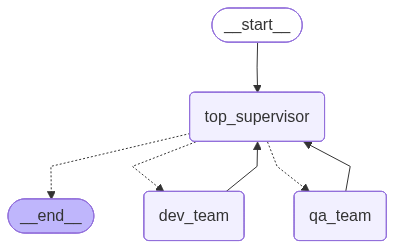

In [16]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        hierarchical_system.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [6]:
# Test hierarchical system
print("Testing hierarchical system...")
result = hierarchical_system.invoke(
    {"messages": ["Start new project"]},
    config={"recursion_limit": 50}  # Increase limit as safety measure
)

print("\nFinal messages:")
for i, message in enumerate(result["messages"], 1):
    print(f"{i}. {message}")

Testing hierarchical system...

Final messages:
1. content='Start new project' additional_kwargs={} response_metadata={} id='cada775f-6f27-4683-92d0-9297c9631474'
2. content='[BACKEND]: Development complete' additional_kwargs={} response_metadata={} id='aa71f922-6d29-4c39-b183-8eb8b726695f'
3. content='[FRONTEND]: Development complete' additional_kwargs={} response_metadata={} id='03b9f903-eb4e-4830-9457-2e0cdc764940'
4. content='[TESTER]: Testing complete' additional_kwargs={} response_metadata={} id='d588c559-9b4c-485c-b4b2-a0b2567d4221'
5. content='[SECURITY]: Security analysis complete' additional_kwargs={} response_metadata={} id='f7725d5f-d2d1-49d3-9c64-43c4f912cd21'


### 5. Custom Workflow Architecture
This approach defines explicit workflows with some dynamic routing capabilities.


In [1]:
from typing import Literal
# from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command

# model = ChatOpenAI(temperature=0)

def document_parser(state: MessagesState) -> Command[Literal["content_analyzer"]]:
    """Parse incoming documents"""
    return Command(
        goto="content_analyzer",
        update={"messages": [f"[PARSER]: Document parsed - detected format: PDF, 10 pages"]}
    )

def content_analyzer(state: MessagesState) -> Command[Literal["text_processor", "image_processor"]]:
    """Analyze content type and route accordingly"""
    # Simulate content analysis
    content_type = "mixed"  # Could be "text", "image", or "mixed"
    
    if content_type in ["text", "mixed"]:
        return Command(
            goto="text_processor",
            update={"messages": [f"[ANALYZER]: Content analyzed - contains text and images"]}
        )
    else:
        return Command(goto="image_processor")

def text_processor(state: MessagesState) -> Command[Literal["summarizer"]]:
    """Process text content"""
    return Command(
        goto="summarizer",
        update={"messages": [f"[TEXT_PROC]: Text extracted and cleaned - 2,500 words"]}
    )

def image_processor(state: MessagesState) -> Command[Literal["summarizer"]]:
    """Process image content"""
    return Command(
        goto="summarizer",
        update={"messages": [f"[IMAGE_PROC]: Images processed - 5 charts and 3 diagrams analyzed"]}
    )

def summarizer(state: MessagesState) -> Command[Literal[END]]:
    """Generate final summary"""
    return Command(
        goto=END,
        update={"messages": [f"[SUMMARIZER]: Final summary generated - key insights extracted"]}
    )

# Build custom workflow
builder = StateGraph(MessagesState)
builder.add_node("document_parser", document_parser)
builder.add_node("content_analyzer", content_analyzer)
builder.add_node("text_processor", text_processor)
builder.add_node("image_processor", image_processor)
builder.add_node("summarizer", summarizer)

# Define explicit workflow
builder.add_edge(START, "document_parser")

custom_workflow = builder.compile()

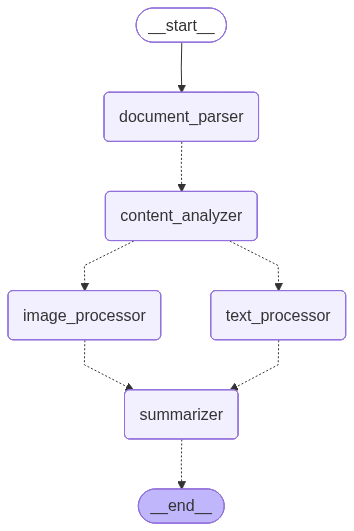

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        custom_workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [3]:
# Test custom workflow
result = custom_workflow.invoke({"messages": ["Process uploaded document"]})
for message in result["messages"]:
    print(message)

content='Process uploaded document' additional_kwargs={} response_metadata={} id='2bbf85d2-8270-4297-9724-fc94fffe368f'
content='[PARSER]: Document parsed - detected format: PDF, 10 pages' additional_kwargs={} response_metadata={} id='8f0ff915-3f58-4bb5-a309-0d61315e320a'
content='[ANALYZER]: Content analyzed - contains text and images' additional_kwargs={} response_metadata={} id='5d8fac80-552a-4cf7-8dce-e61c3c176c7b'
content='[TEXT_PROC]: Text extracted and cleaned - 2,500 words' additional_kwargs={} response_metadata={} id='3e0b581b-81ea-4d89-9027-9c4753b33327'
content='[SUMMARIZER]: Final summary generated - key insights extracted' additional_kwargs={} response_metadata={} id='d6106ced-1d98-419f-ab0f-44c7afdb5ad1'
